In [12]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pybedtools
import pandas as pd
from tqdm import tqdm
import dill as pickle
import multiprocess

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
sns.set_style('white')
sns.set_context("paper", font_scale = 3)
new_rc_params = {
    'text.usetex': False,
    'svg.fonttype': 'none',
    'figure.figsize': (20, 10),
    'font.family': 'Helvetica',
}
matplotlib.rcParams.update(new_rc_params)


In [8]:
def process_loop_catalog_dataset(dataset_path):
    """
    Process the loop catalog dataset to extract relevant columns and convert them to a PyRanges object.
    """
    df = pd.read_csv(dataset_path, compression='gzip', header=None, sep='\t')
    extra = df[3].str.split(r',|:|-', expand=True)
    df = pd.concat([df.drop(columns=[3]), extra], axis=1)
    return df

In [21]:
cores = 2

def calc_overlap_proportions(dataset, col1, col2, type, save=True, prefix=''):
    overlaps = []
    n_1 = []
    n_2 = []

    def calc_per_idx (i):
        print(i)
        try:
            df_1 = process_loop_catalog_dataset(dataset.loc[i, col1])
            pbt_1 = pybedtools.BedTool.from_dataframe(df_1)
            df_2 = process_loop_catalog_dataset(dataset.loc[i, col2])
            pbt_2 = pybedtools.BedTool.from_dataframe(df_2)
            overlap_1 = pbt_2.pair_to_pair(pbt_1, type=type).to_dataframe(disable_auto_names=True, header=None)
            return overlap_1, len(pbt_1), len(pbt_2)
        except:
            return pd.DataFrame(), 0, 0

    pool = multiprocess.Pool(cores)
    results = list(pool.imap(calc_per_idx, range(len(dataset))))
    pool.join()
    pool.close()

    overlaps = [r[0] for r in results]
    n_1 = [r[1] for r in results]
    n_2 = [r[2] for r in results]
        
    if save:
        outfile = f"{prefix}_overlaps_{col1.replace(' ', '_')}_{col2.replace(' ', '_')}_{type}.pickle"
        pickle.dump((overlaps, n_1, n_2), open(outfile, 'wb'))
    return (overlaps, n_1, n_2)

In [ ]:
hiccup_dataset = pd.read_csv('./LoopCatalog_1kb_5kb_Hiccups.csv')
hiccup_dataset["normalization"] = hiccup_dataset["Primary Name"].str.split('(',expand=True)[1].str.rstrip(')')

overlaps, n_1, n_2, overlaps_scores_1, overlaps_scores_2 = calc_overlap_proportions(hiccup_dataset, '1kb HiC Longrange', '5kb HiC Longrange', 'either')

  4%|▍         | 4/99 [00:26<14:29,  9.15s/it]

In [22]:
fithic_dataset = pd.read_csv('./LoopCatalog_FitHiChip.csv')

fithic_dataset["normalization"] = fithic_dataset["Primary Name"].str.split('(',expand=True)[1].str.rstrip(')')

In [ ]:
overlaps, n_1, n_2, overlaps_scores_1, overlaps_scores_2 = calc_overlap_proportions(fithic_dataset, '5kb FH Longrange (Unfiltered)', '10kb FH Longrange (Unfiltered)', 'either', save=True, prefix="fithic")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [ ]:
overlaps

In [282]:
def prop_high_in_low (dataset, overlaps, n_1, n_2, idx):
    prop_overlapping = np.array([len(overlaps[i].iloc[:,[8,9,10,11,12,13]].drop_duplicates())/n_1[i] if (overlaps[i] is not None and n_1[i] is not None) else None for i in range(len(overlaps))]).astype(np.float64)

    valid_idx = ~np.isnan(prop_overlapping[idx])
    filtered_props = prop_overlapping[idx][valid_idx]
    filtered_hue = dataset["Std Sample Name"].iloc[idx][valid_idx]

    sns.histplot(x=filtered_props, palette="deep", linewidth=5, fill=True, alpha=0.5, bins=20, element="step", legend=False)

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=1,)
    # plt.tight_layout()
    plt.xlim(0, 1)

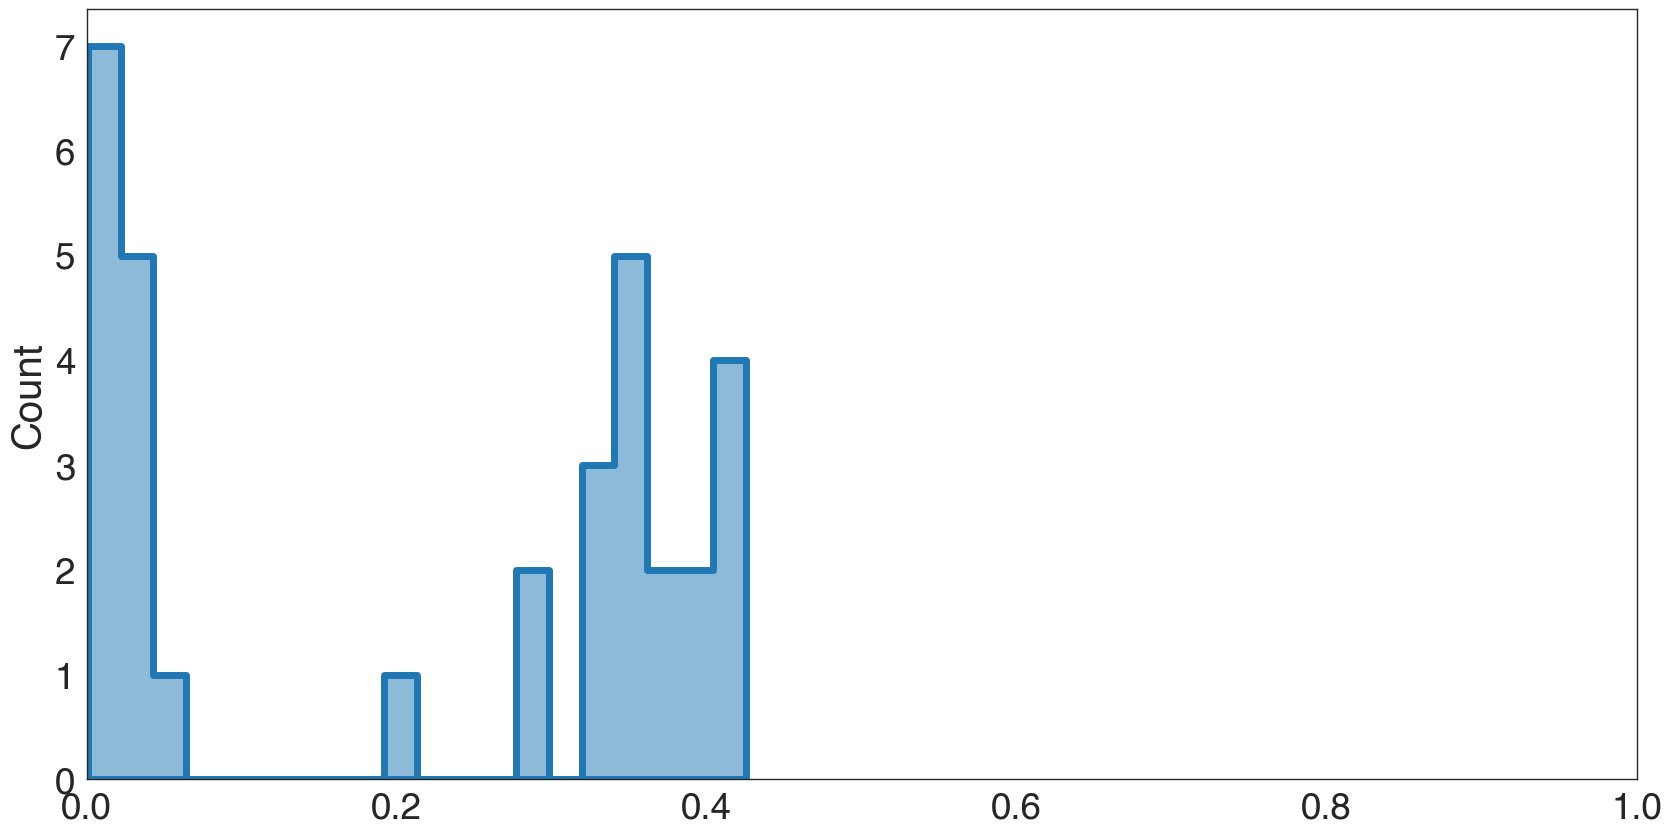

In [283]:
prop_high_in_low(fithic_dataset, overlaps, n_1, n_2, np.where(fithic_dataset["normalization"] == "raw")[0])